# Neuronal Functional Connectivity Estimation

In [46]:
from copy import deepcopy
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from scipy import linalg
import seaborn as sns
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

import evals
import globals as glb
import utils
import plot_utils
from data_loader import SpontaneousRecordingData
from data_loader import GratingStimuliRecordingData # Recording with Grating Stimuli
from data_loader import VisualStimuliRecordingData # Recording with Image Stimuli

from NearestPSD import shrinking, nearest_correlation
from data_sampler import MissingTraceSampler, PartialSpontRecordingData
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The datasets we use for this project is published by Carsen Stringer at https://janelia.figshare.com/articles/dataset/Recordings_of_10k_neurons_in_V1_during_drifting_gratings/6214019  
  
<font color=brown> To run the following code, please make sure you have the dataset downloaded locally and set its local path to the 'DATA_DIR' variable below.</font>

# Load Spontaneous Activity Datasets
Change the following DATA_DIR to your local data directory!

In [8]:
DATA_DIR = "../Data/"
spont_mat = scipy.io.loadmat(DATA_DIR + "dbspont.mat").get("db")[0]  # 9 datasets of recordings

In [9]:
# Session 1: Around 120 mins
SIDX = 0
spont0_fp = DATA_DIR + "_".join(["spont", spont_mat[SIDX][glb.SESSION_NAME][0], spont_mat[SIDX][glb.REC_DATE][0]])
spont_dataset0 = SpontaneousRecordingData(data_fp=spont0_fp)

Removing 1 all-zero columns


In [10]:
# Basic statistics about the dataset
spont_dataset0.display_field_shapes()

neuron counts: 11983
layer counts: 9
Layer 0: 1131 neurons
Layer 1: 1183 neurons
Layer 2: 1218 neurons
Layer 3: 1321 neurons
Layer 4: 1415 neurons
Layer 5: 1471 neurons
Layer 6: 1418 neurons
Layer 7: 1440 neurons
Layer 8: 1386 neurons
timestamp counts 21054
running speed (21054, 1)
face motion mask (240, 320, 1000)
face motion svd (21054, 1000)
avg frame (240, 320)
pupil area (21054, 1)
pupil com (21054, 2)
eye motion svd (21054, 500)
whisker motion mask (216, 304, 500)
whisker motion SVD (21054, 500)


In [11]:
# Randomly selected neuron traces
spont_dataset0.display_aggregated_stats()

fsp:
- mean: [63.403896 50.399834 44.502342 ... 50.019924 59.62232  80.88147 ]
- std: [142.98846  116.771225 116.605606 ... 130.43459  152.64905  183.18759 ]
running speed:
-mean: 3.9668139108024194
- std: 9.045952631537109
- range: 0.00 ~ 60.30
pupil area:
- mean: 902.2317785988538
- std: 374.5450626253281
- range: 234.56 ~ 2550.95


{'fsp': {'mean': array([63.403896, 50.399834, 44.502342, ..., 50.019924, 59.62232 ,
         80.88147 ], dtype=float32),
  'std': array([142.98846 , 116.771225, 116.605606, ..., 130.43459 , 152.64905 ,
         183.18759 ], dtype=float32)},
 'run_speed': {'mean': 3.9668139108024194, 'std': 9.045952631537109},
 'pupil_area': {'mean': 902.2317785988538, 'std': 374.5450626253281}}

Pupil Area data NaN percentage:  0.0


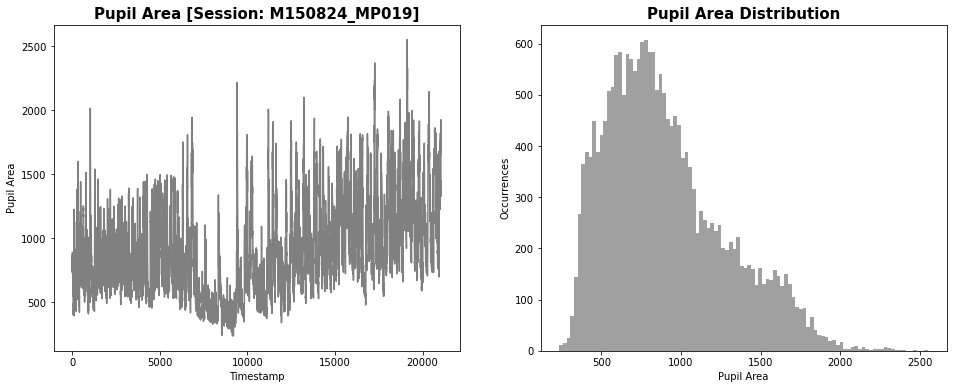

In [12]:
# Pupil Area
spont_dataset0.display_pupil_area()

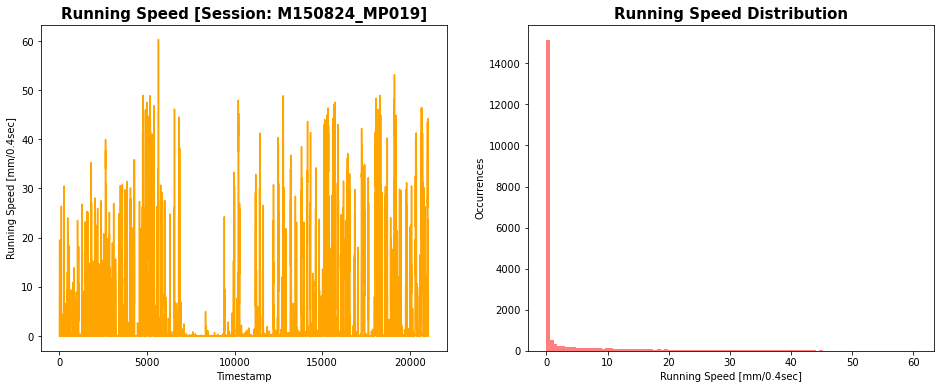

In [14]:
# Running speed time series
spont_dataset0.display_run_speed()

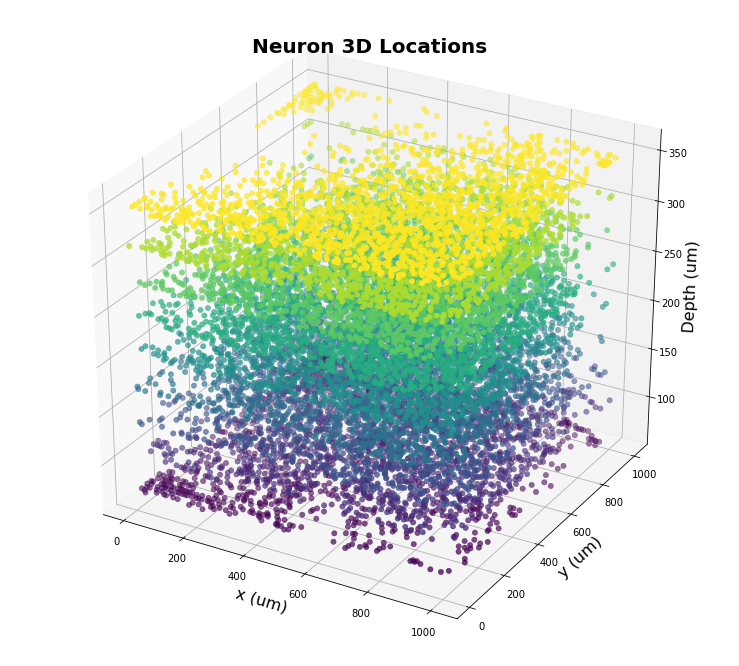

In [15]:
# Neuron locations
plt.figure(figsize=(13, 12))
spont_dataset0.display_neuron_3d(session_name="Spontaneous Session 0")

In [16]:
# Number of neurons per layer
for layer in range(9):
    print("Layer", layer,": ", spont_dataset0.get_layer_fsp(layer).shape)

Layer 0 :  (1131, 21054)
Layer 1 :  (1183, 21054)
Layer 2 :  (1218, 21054)
Layer 3 :  (1321, 21054)
Layer 4 :  (1415, 21054)
Layer 5 :  (1471, 21054)
Layer 6 :  (1418, 21054)
Layer 7 :  (1440, 21054)
Layer 8 :  (1386, 21054)


In [17]:
# spont_dataset0.display_single_neuron_fsp(999)#XM: neuron idx range is 0~11982
# spont_dataset0.display_single_neuron_fsp(64)

# spont_dataset0.display_single_neuron_fsp(1168)

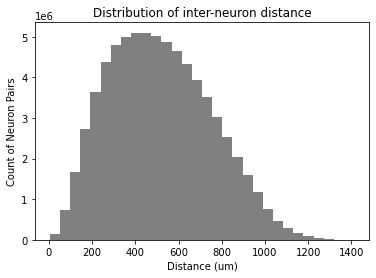

In [18]:
# Inter-neuron Distance Distribution
dist = spont_dataset0.inter_neuron_distance(plot=True)

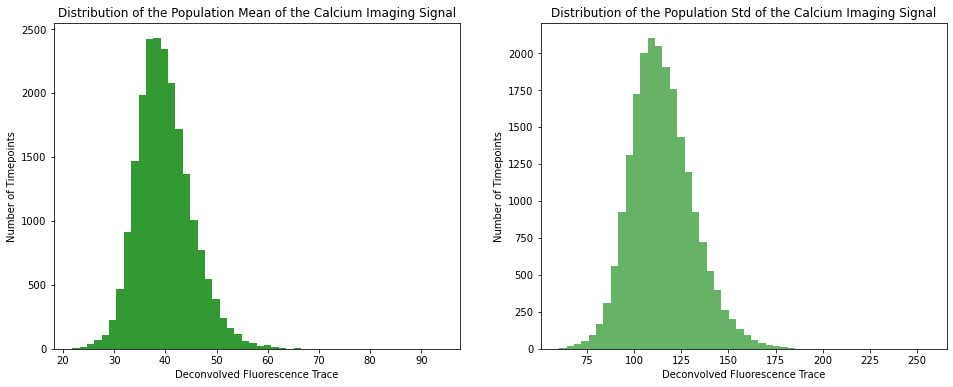

In [19]:
# Display Calcium Trace Mean and Std Distribution
spont_dataset0.display_fsp_distribution_all_time()

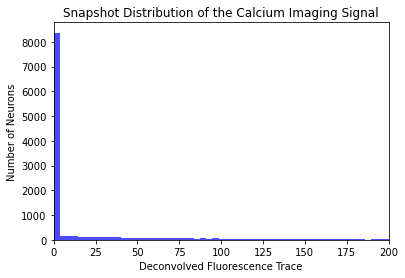

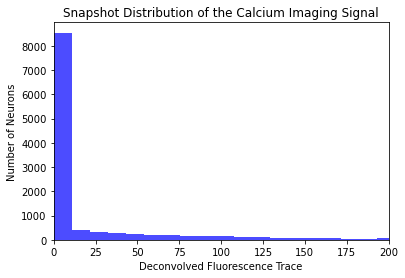

In [20]:
# Display Calcium Trace Distribution at a Specific Instant
spont_dataset0.display_fsp_distribution_instant(timepoint=1000, bins=500)
spont_dataset0.display_fsp_distribution_instant(timepoint=10, bins=150)

# Load all 9 datasets
NOTE: Change the DATA_DIR to your local path of the data directory!
  
While loading the datasets, the loader automatically removes the ill-formatted entries.

In [21]:
# Input data matrices
SpontData = dict()

for SIDX in range(9):
    # Load Data
    spont_fp = DATA_DIR + "_".join(["spont", spont_mat[SIDX][glb.SESSION_NAME][0], 
                                    spont_mat[SIDX][glb.REC_DATE][0]])
    spont_dataset = SpontaneousRecordingData(data_fp=spont_fp)
    SpontData[SIDX] = spont_dataset
    print(SIDX, spont_dataset.fsp.shape)
    

## Model Input
<font color=red> Can be modified: </font> For each of the 9 datasets, we randomly select 200 neurons at each depth and take their recorded activity from approximately minute 10 to minute 30. We intentionally omit the first 10 minutes of recording to avoid a burn-in period when the experimented mouse was not well adapted yet to the new environment. 

In [22]:
# Select samples from approximately minute 10 - 30
Start_tp = 1800
End_tp = 5400
Tps = End_tp - Start_tp
Neuron_count =  200
c_percentages = np.arange(0.35, 1, 0.05)